<a href="https://colab.research.google.com/github/Lorddickenstein/FSLRwithNLP/blob/main/Application/CNN_Model_Experiment2_Letters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Activation, Dense, Flatten, MaxPool2D, Conv2D, Dropout, BatchNormalization
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import glob
import warnings
import random
import shutil
import itertools
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation

In [9]:
# Change the root folder when experimenting on a different folder
root = '/content/drive/MyDrive/Colab Notebooks/Datasets/OurDataset/Experiments/Experiment_2'

letters = ['A', 'B', 'C', 'D', 'E',
           'F', 'G', 'H', 'I', 'J',
           'K', 'L', 'M', 'N', 'O',
           'P', 'Q', 'R', 'S', 'T',
           'U', 'V', 'W', 'X', 'Y',
           'Z']

In [4]:
def make_dir(path, class_obj):
  for obj in class_obj:
    path_class = os.path.join(path, obj)
    os.makedirs(path_class)

In [5]:
letters_root = os.path.join(root, 'Letters')

# Create Train, Valid, Test directories
train_path = os.path.join(letters_root, 'Train')
valid_path = os.path.join(letters_root, 'Valid')
test_path = os.path.join(letters_root, 'Test')

if os.path.isdir(train_path) is False:
  make_dir(train_path, letters)
  make_dir(valid_path, letters)
  make_dir(test_path, letters)
else:
  print("Directory already exists.")


# Populate Train, Valid and Test Folders

In [6]:
# Make a folder for every classes
dataset_experiment = '/content/drive/MyDrive/Colab Notebooks/Datasets/OurDataset/Experiments/Dataset_Experiments/Letters'
if os.path.isdir(dataset_experiment) is False:
  make_dir(dataset_experiment, letters)
else:
  print("Directory already exists.")

In [7]:
# Copy Dataset from Renamed Dataset to Experiment Dataset
dataset_root = '/content/drive/MyDrive/Colab Notebooks/Datasets/OurDataset/Raw_Dataset_Renamed'
dataset_path = os.path.join(dataset_root, 'Letters')
for letter in letters:
  path_class = os.path.join(dataset_path, letter)
  path_class_dest = os.path.join(dataset_experiment, letter)
  for item in os.listdir(path_class):
    shutil.copy(os.path.join(path_class, item), path_class_dest)

In [8]:
# Copy all images from dataset experiments folder to train folder
for letter in letters:
  path_class = os.path.join(dataset_experiment, letter)
  path_class_dest = os.path.join(train_path, letter)
  for item in os.listdir(path_class):
    shutil.copy(os.path.join(path_class, item), path_class_dest)

In [10]:
valid_size = 20
test_size = 10

# Valid
for letter in letters:
  path_class = os.path.join(train_path, letter)
  os.chdir(path_class)
  if len(os.listdir(path_class)) != 0:
    for item in random.sample(glob.glob(letter + '_*'), valid_size):
      shutil.move(item, os.path.join(valid_path, letter))

# Test
for letter in letters:
  path_class = os.path.join(train_path, letter)
  os.chdir(path_class)
  if len(os.listdir(path_class)) != 0:
    for item in random.sample(glob.glob(letter + '_*'), test_size):
      shutil.move(item, os.path.join(test_path, letter))

In [11]:
# Verify number of images in Experiment
for letter in letters:
  train_path_experiment = os.path.join(train_path, letter)
  valid_path_experiment = os.path.join(valid_path, letter)
  test_path_experiment = os.path.join(test_path, letter)
  print(letter, len(os.listdir(train_path_experiment)), len(os.listdir(valid_path_experiment)), len(os.listdir(test_path_experiment)))

A 64 20 10
B 63 20 10
C 60 20 10
D 64 20 10
E 68 20 10
F 64 20 10
G 63 20 10
H 60 20 10
I 65 20 10
J 0 0 0
K 67 20 10
L 62 20 10
M 60 20 10
N 57 20 10
O 59 20 10
P 57 20 10
Q 55 20 10
R 53 20 10
S 57 20 10
T 56 20 10
U 52 20 10
V 65 20 10
W 66 20 10
X 63 20 10
Y 69 20 10
Z 0 0 0


# Preprocess Image

In [12]:
image_size = (224, 224)

In [13]:
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=image_size, classes=letters, batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=image_size, classes=letters, batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=image_size, classes=letters, batch_size=10)

Found 1469 images belonging to 26 classes.
Found 480 images belonging to 26 classes.
Found 240 images belonging to 26 classes.


In [14]:
# Subtract empty class
assert train_batches.n == 1469
assert valid_batches.n == (20*26) - 40
assert test_batches.n == (10*26) - 20

In [15]:
imgs, labels = next(train_batches)

In [16]:
# Plot 10 sample images
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 10, figsize=(20, 20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

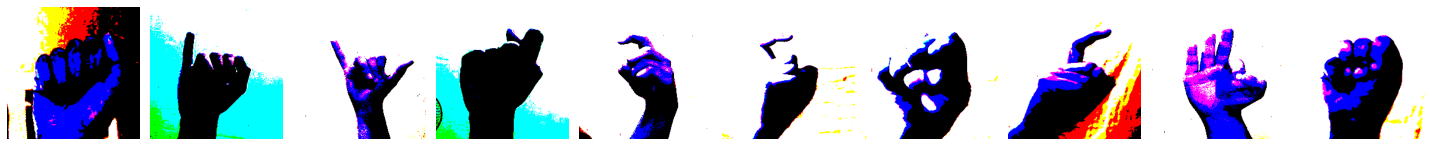

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]


In [17]:
plotImages(imgs)
print(labels)

# Build and Train Model

In [18]:
# Count the total classes that the model must know
total_classes = len(os.listdir(train_path))
print(total_classes)

26


# Model #1
Choose only one model.

In [20]:
# Create the Sequential Model
model = Sequential()

# Add Layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(total_classes, activation='softmax'))

# Summary of layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               2

# Model #2 VGG16
Choose only one model.

In [ ]:
# VGG16 Model
vgg16_model = keras.applications.vgg16.VGG16()

553476096/553467096 [==============================] - 4s 0us/step


In [ ]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# Create the model
model = Sequential()

# Copy the layer from the vgg16_model to model
for layer in vgg16_model.layers[:-1]:
  model.add(layer)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [ ]:
# Add the prediction layer
model.add(Dense(total_classes, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

# Train the model

In [21]:
# Create the connection and train the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
model.fit(x=train_batches, validation_data=valid_batches, batch_size=15, epochs=20)

Epoch 1/20
147/147 [==============================] - 147s 992ms/step - loss: 32.5017 - accuracy: 0.0674 - val_loss: 2.8809 - val_accuracy: 0.2188
Epoch 2/20
147/147 [==============================] - 145s 989ms/step - loss: 2.6345 - accuracy: 0.2791 - val_loss: 2.3627 - val_accuracy: 0.3562
Epoch 3/20
147/147 [==============================] - 146s 991ms/step - loss: 1.6788 - accuracy: 0.5085 - val_loss: 2.0474 - val_accuracy: 0.4208
Epoch 4/20
147/147 [==============================] - 146s 991ms/step - loss: 1.0387 - accuracy: 0.6991 - val_loss: 2.1660 - val_accuracy: 0.4500
Epoch 5/20
147/147 [==============================] - 146s 990ms/step - loss: 0.6447 - accuracy: 0.8026 - val_loss: 2.1739 - val_accuracy: 0.4979
Epoch 6/20
147/147 [==============================] - 145s 984ms/step - loss: 0.4902 - accuracy: 0.8496 - val_loss: 2.1383 - val_accuracy: 0.4750
Epoch 7/20
147/147 [==============================] - 145s 988ms/step - loss: 0.3296 - accuracy: 0.9013 - val_loss: 2.3144 

In [22]:
# Evaluate the model with test_sets
print(model.evaluate(test_batches))

24/24 [==============================] - 6s 232ms/step - loss: 2.7944 - accuracy: 0.5167
[2.7943549156188965, 0.5166666507720947]


In [23]:
predictions = model.predict(x=test_batches, verbose=0)

# Confusion Matrix

In [24]:
# Setup the confusion matrix
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [25]:
test_batches.class_indices

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25}

In [26]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[0 0 1 1 2 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 2]
 [0 1 0 2 0 0 0 0 0 2 0 2 0 1 1 0 0 0 0 0 1 0 0 0]
 [2 1 0 0 2 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0]
 [0 1 0 1 0 2 1 1 0 2 0 0 1 0 0 0 0 0 0 0 0 0 1 0]
 [0 1 0 0 1 0 0 0 0 2 1 1 0 0 1 0 0 1 0 0 1 0 0 1]
 [0 0 1 0 0 1 1 0 0 2 0 1 0 1 0 0 0 1 1 0 0 0 1 0]
 [1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 2 2 0]
 [0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 2 1 0]
 [0 0 3 0 0 2 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 1 0 3 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1]
 [2 0 1 1 0 0 2 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0]
 [1 0 1 0 0 0 0 3 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 1]
 [0 1 0 0 0 0 1 2 0 0 0 0 0 2 0 0 0 0 0 0 0 2 2 0]
 [1 0 0 2 0 0 0 1 0 2 0 0 0 1 3 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 2 1 1 2]
 [1 1 0 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0]
 [1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1]
 [0 0 1 0 1 0 0 1 1 1 1 0 1 0 1 0 0 0 0 1 0 0 1 0]
 [0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 2 0 0 

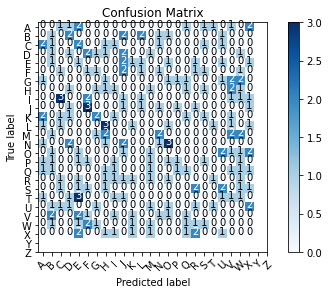

In [27]:
# Plot the confusion matrix
cm_plot_labels = letters
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Save the Model

In [28]:
# save the model
model_name = 'Fingerspell_Detector_Experiment2.h5'
path = '/content/drive/MyDrive/Colab Notebooks/CNN Models/' + model_name
model.save(path)